<a href="https://colab.research.google.com/github/440g/Machine5/blob/Open-Binary/Open-Binary/bianry_open_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 1. Import Libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
from scipy.stats import expon, reciprocal

# 2. Load Data

In [ ]:
drive.mount('/content/drive')

# Load datasets
mon_features = pd.read_csv('/content/drive/MyDrive/Machine5/datasets/mon_features.csv')
unmon_features = pd.read_csv('/content/drive/MyDrive/Machine5/datasets/unmon_features.csv')

# Assign labels
mon_labels = np.ones(len(mon_features))  # 1 for monitored
unmon_labels = -np.ones(len(unmon_features))  # -1 for unmonitored

# Combine features and labels
features_combined = pd.concat([mon_features, unmon_features], axis=0, ignore_index=True)
labels_combined = np.concatenate([mon_labels, unmon_labels])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#check the shape of mon_features
print(mon_features.head())

#check the shape of unmon_features
print(unmon_features.head())

   total_num  total_sum_dir  total_avg  inpkt_num  inpkt_avg  inpkt_sum  \
0       1421        -603648   4.315749       1300   4.292023    5579.63   
1        518        -183296   4.611815        438   4.673242    2046.88   
2       1358        -574464   5.488969       1240   5.459452    6769.72   
3       1446        -615424   5.995512       1324   5.948693    7876.07   
4       1406        -602112   4.698869       1291   4.663873    6021.06   

   inpkt_num_frac_total  inpkt_avg_ordering  inpkt_std_ordering  \
0              0.914849          704.106154          398.486335   
1              0.845560          264.406393          150.591146   
2              0.913108          668.259677          381.878642   
3              0.915629          713.503021          406.205288   
4              0.918208          694.740511          395.028889   

   inpkt_num_frac_outpkt  inpkt_sum_firstn  outpkt_num  outpkt_avg  \
0              10.743802             16.10         121    4.570661   
1     

# 3. Preprocess Data

In [4]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    features_combined, labels_combined, test_size=0.2, random_state=50
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Build and Train the SVM Model

In [5]:
# Train SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

# Evaluate model on test data
y_pred = svm_model.predict(X_test_scaled)

# Calculate basic evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.8000
Confusion Matrix:
[[1165  826]
 [ 334 3475]]


# 5. Hyperparameter Tuning

In [6]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'C': [100, 1000],
    'gamma': [0.1],
    'kernel': ['rbf']
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_
print(f"Best parameters (GridSearchCV): {best_params}")


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  29.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  30.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  28.8s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 2.3min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 2.3min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 2.2min
Best parameters (GridSearchCV): {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [7]:
y_pred = best_svm_model.predict(X_test_scaled)
# Evaluation with the best parameters
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with best parameters: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix with best parameters\n {conf_matrix}")

Accuracy with best parameters: 0.8324
Confusion Matrix with best parameters
 [[1392  599]
 [ 373 3436]]


In [8]:
# Define hyperparameter distributions for RandomizedSearchCV
param_distributions = {
    'C': reciprocal(1, 1000),
    'gamma': expon(scale=0.1),
    'kernel': ['rbf'],
    'class_weight': ['balanced', None]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(SVC(), param_distributions, n_iter=50, cv=2, scoring='accuracy', verbose=2, random_state=50, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

# Retrieve the best model
best_params_random = random_search.best_params_
best_svm_model_random = random_search.best_estimator_
print(f"Best parameters (RandomizedSearchCV): {best_params_random}")


Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters (RandomizedSearchCV): {'C': 66.12986882494312, 'class_weight': None, 'gamma': 0.1598300699529709, 'kernel': 'rbf'}


# 6. Evaluate the Tuned Model

In [9]:
# Predict using the best model from RandomizedSearchCV
y_pred_random = best_svm_model_random.predict(X_test_scaled)

# Evaluate model performance
accuracy_best = accuracy_score(y_test, y_pred_random)
conf_matrix_best = confusion_matrix(y_test, y_pred_random)
precision = precision_score(y_test, y_pred_random, pos_label=1)
recall = recall_score(y_test, y_pred_random, pos_label=1)

# Calculate ROC and Precision-Recall AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_random, pos_label=1)
roc_auc = auc(fpr, tpr)
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_random, pos_label=1)
pr_auc = auc(recall_values, precision_values)

# Print metrics
print(f"Accuracy (Tuned Model): {accuracy_best:.4f}")
print(f"Confusion Matrix (Tuned Model):\n{conf_matrix_best}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")


Accuracy (Tuned Model): 0.8329
Confusion Matrix (Tuned Model):
[[1410  581]
 [ 388 3421]]
Precision: 0.8548
Recall: 0.8981
ROC AUC: 0.8032
Precision-Recall AUC: 0.9099


# 7. Visualize Results

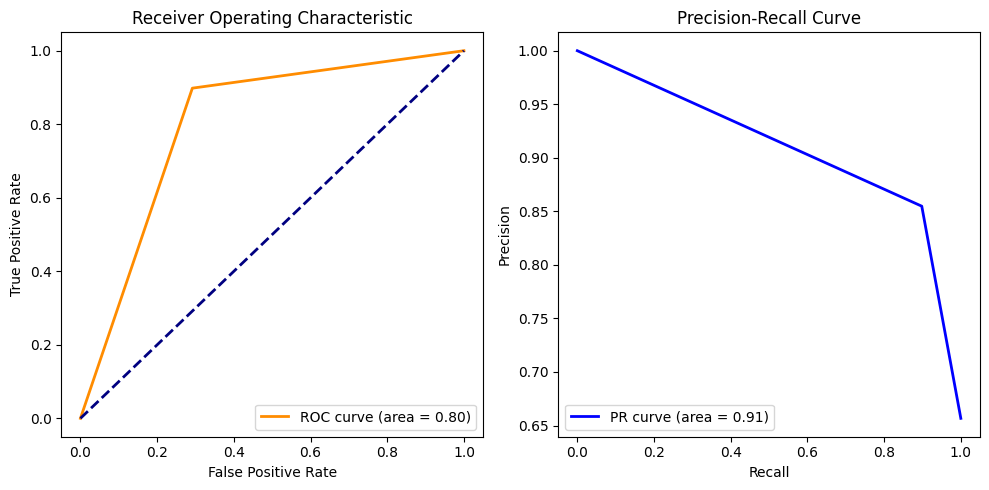

In [10]:
# Plot ROC and Precision-Recall curves
plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()